In [1]:
# Pytorch
import torch
import torch.nn as nn

import copy
import statistics
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
from torch.distributions import Beta

In [2]:
#модель для проверки class Network
def create_model(input_var, output_var, hidden1, hidden2):
    model = nn.Sequential(
            nn.Linear(input_var, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, output_var),
            nn.Sigmoid())
    return model

In [3]:
model = create_model(2, 1, 3, 4)
model

Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)

1 task

In [4]:
class Network(nn.Module):
    def __init__(self, model, dropout_p):
        super(Network, self).__init__()
        self.model = model
        self.dropout_p = dropout_p
         
        
    def mean_forward(self, x, n_iter):
        results = []
        for i in range(n_iter):
            model_copy = copy.deepcopy(self.model)
            state_dict = model_copy.state_dict()
            state_dict_v2 = copy.deepcopy(state_dict)
            for key, value in state_dict_v2.items():
                if 'weight' in key:
                    output = nn.functional.dropout(value, self.dropout_p, training=True)
                    state_dict_v2[key] = output
            model_copy.load_state_dict(state_dict_v2, strict=True)
            output = model_copy(x)
            results.append(output)
        result = [tensor.item() for tensor in results]
        mean = round(statistics.mean(result), 3)
        std = round(statistics.stdev(result), 3)
        print(f'Mean: {mean}')
        print(f'Std: {std}')   

In [5]:
net = Network(model, 0.5)
net

Network(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [6]:
input_data = torch.Tensor([3, 8])
net.mean_forward(input_data, 100)

Mean: 0.438
Std: 0.273


2 task

In [7]:
#создание датасета с четкими границами
X = torch.rand(2500,2)                       
Y = (torch.sum((X - 0.5)**2, axis=1) < 0.1).float().view(-1,1)

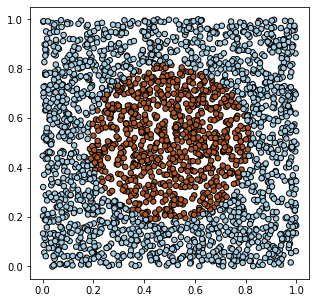

In [8]:
import matplotlib.pyplot as plt                              
 
plt.figure (figsize=(5, 5))                                  
plt.scatter(X.numpy()[:,0], X.numpy()[:,1], c=Y.numpy()[:,0], 
            s=30, cmap=plt.cm.Paired, edgecolors='k')        
plt.show()  

In [9]:
def split(dataset):

    X, Y = dataset

    Y = np.expand_dims(Y, axis=1)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

    print('X_train: {}, X_test: {}, Y_train: {}, Y_test: {}'.format(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape))
    return X_train, X_test, Y_train, Y_test

In [10]:
class CustomDataset:
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.target[idx]

        return x, y

In [11]:
class FeedForwardNetwork(nn.Module):
    
    def __init__(self, layer_sizes):
        super().__init__()

        self.layer_sizes = layer_sizes

        self.layers = nn.ModuleList()

        for i, _ in enumerate(self.layer_sizes):
            if i == len(self.layer_sizes) - 1:
                break
            self.layers.append(nn.Linear(self.layer_sizes[i], self.layer_sizes[i+1]))
        
    def forward(self, x):

        x = x.reshape(-1, self.layer_sizes[0])

        for i in range(0, len(self.layers)-1):
            x = F.relu(self.layers[i](x))

        x = torch.sigmoid(self.layers[-1](x))

        return x

    def freeze(self):
        for param in self.parameters():
            param.requires_grad = False
    
    def unfreeze(self):
        for param in self.parameters():
            param.requires_grad = True


        return net

In [12]:
def train(net, train_epochs, train_dataloader, optimizer, set):

    losses = list()
    train_accuracies = list()
    best_accuracy = 0.0

    for epoch in range(train_epochs):
        net.train()
        for batch_idx, (data, target) in enumerate(train_dataloader):
            # Optimize parameters
            net.zero_grad()
            outputs = net(data)
            loss = F.binary_cross_entropy_with_logits(outputs, target, size_average=False)
            loss.backward()
            optimizer.step()
            losses.append(loss.clone().detach().numpy())

            # Check training accuracy
            binary_predictions = (outputs>0.5).float()
            accuracy = (binary_predictions == target).float().mean()
            train_accuracies.append(accuracy)
            

    return losses, train_accuracies

In [13]:
def check_accuracy(net, test_dataloader):

    net.eval()
    net.freeze()

    test_accuracies = list()
    for batch_idx, (data, target) in enumerate(test_dataloader):
        predictions = net(data)
        binary_predictions = (predictions>0.5).float()
        correct = (binary_predictions == target).float().mean()
        test_accuracies.append(correct.detach().numpy())
    return np.mean(test_accuracies)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [15]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True, drop_last=True)

In [17]:
TRAIN_EPOCHS = 100

layer_sizes1 = [2, 4, 9, 16, 9, 4, 1]
net_dataset = FeedForwardNetwork(layer_sizes1)

# Set the optimizer
optimizer = optim.SGD(net_dataset.parameters(), lr=0.01)
losses, train_accuracies = train(net_dataset, TRAIN_EPOCHS, train_dataloader, optimizer, 0)

c:\Users\Acer\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [18]:
print('dataset train set accuracy: {}'.format(check_accuracy(net_dataset, train_dataloader)))
print('dataset test set accuracy: {}'.format(check_accuracy(net_dataset, test_dataloader)))

dataset train set accuracy: 0.671875
dataset test set accuracy: 0.6800000071525574


In [19]:
#сохранение модели
Path = './dataset0.pth'
torch.save(net_dataset.state_dict(), Path)

In [20]:
#создание 2 датасета с нечеткими границами
X1, Y1 = make_classification(n_samples=1200, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.6], flip_y=0, random_state=1)
X1 = torch.Tensor(X1)
Y1 = torch.Tensor(Y1)

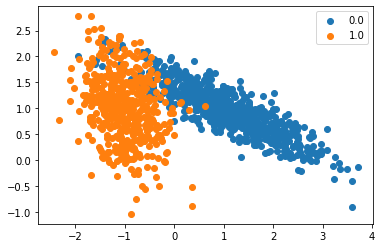

In [21]:
counter = Counter(Y1.numpy())
for label, _ in counter.items():
	row_ix = where(Y1.numpy() == label)[0]
	pyplot.scatter(X1.numpy()[row_ix, 0], X1.numpy()[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

In [22]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1.view(-1,1), test_size=0.33, random_state=42)

In [23]:
train_dataset1 = CustomDataset(X1_train, y1_train)
test_dataset1 = CustomDataset(X1_test, y1_test)

In [24]:
train_dataloader1 = DataLoader(train_dataset1, batch_size=100, shuffle=True, drop_last=True)
test_dataloader1 = DataLoader(test_dataset1, batch_size=100, shuffle=True, drop_last=True)

In [25]:
TRAIN_EPOCHS = 100

layer_sizes1 = [2, 4, 9, 16, 9, 4, 1]
net_dataset1 = FeedForwardNetwork(layer_sizes1)

# Set the optimizer
optimizer = optim.SGD(net_dataset1.parameters(), lr=0.01)

losses, train_accuracies = train(net_dataset1, TRAIN_EPOCHS, train_dataloader1, optimizer, 1)


In [26]:
print('dataset train set accuracy: {}'.format(check_accuracy(net_dataset1, train_dataloader1)))
print('dataset test set accuracy: {}'.format(check_accuracy(net_dataset1, test_dataloader1)))

dataset train set accuracy: 0.9600000381469727
dataset test set accuracy: 0.9533333778381348


In [27]:
#сохраняю вторую модель
Path1 = './dataset1.pth'
torch.save(net_dataset1.state_dict(), Path1)

загружаю первую тренир. модель

In [28]:
layer_sizes = [2, 4, 9, 16, 9, 4, 1]
net_dataset = FeedForwardNetwork(layer_sizes)

In [29]:
net_dataset.load_state_dict(torch.load(Path))

<All keys matched successfully>

In [30]:
model = net_dataset.eval()

In [31]:
net = Network(model, 0.1)
net

Network(
  (model): FeedForwardNetwork(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=4, bias=True)
      (1): Linear(in_features=4, out_features=9, bias=True)
      (2): Linear(in_features=9, out_features=16, bias=True)
      (3): Linear(in_features=16, out_features=9, bias=True)
      (4): Linear(in_features=9, out_features=4, bias=True)
      (5): Linear(in_features=4, out_features=1, bias=True)
    )
  )
)

In [32]:
input_data = torch.Tensor([0.1, 0.1])
net.mean_forward(input_data, 10)

Mean: 0.001
Std: 0.001


загружаю вторую тренир. модель

In [33]:
net_dataset.load_state_dict(torch.load(Path1))

<All keys matched successfully>

In [34]:
model = net_dataset.eval()

In [35]:
net = Network(model, 0.1)
net

Network(
  (model): FeedForwardNetwork(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=4, bias=True)
      (1): Linear(in_features=4, out_features=9, bias=True)
      (2): Linear(in_features=9, out_features=16, bias=True)
      (3): Linear(in_features=16, out_features=9, bias=True)
      (4): Linear(in_features=9, out_features=4, bias=True)
      (5): Linear(in_features=4, out_features=1, bias=True)
    )
  )
)

In [36]:
input_data = torch.Tensor([-1.5, 2])
net.mean_forward(input_data, 10)

Mean: 0.973
Std: 0.082


3 task

In [37]:
class Network_Beta(nn.Module):
    def __init__(self, model, alpha, beta):
        super(Network_Beta, self).__init__()
        self.model = model
        self.alpha = alpha
        self.beta = beta
         
        
    def mean_forward(self, x, n_iter):
        results = []
        m = Beta(torch.tensor(self.alpha), torch.tensor(self.beta))
        p = m.sample()
        for i in range(n_iter):
            model_copy = copy.deepcopy(self.model)
            state_dict = model_copy.state_dict()
            state_dict_v2 = copy.deepcopy(state_dict)
            for key, value in state_dict_v2.items():
                if 'weight' in key:
                    output = nn.functional.dropout(value, p, training=True)
                    state_dict_v2[key] = output
            model_copy.load_state_dict(state_dict_v2, strict=True)
            output = model_copy(x)
            results.append(output)
        result = [tensor.item() for tensor in results]
        mean = round(statistics.mean(result), 3)
        std = round(statistics.stdev(result), 3)
        print(f'Mean: {mean}')
        print(f'Std: {std}')   

загруж. первую трениров. модель

In [38]:
net_dataset.load_state_dict(torch.load(Path))

<All keys matched successfully>

In [39]:
model = net_dataset.eval()

In [40]:
net = Network_Beta(model, 0.4, 0.6)
net

Network_Beta(
  (model): FeedForwardNetwork(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=4, bias=True)
      (1): Linear(in_features=4, out_features=9, bias=True)
      (2): Linear(in_features=9, out_features=16, bias=True)
      (3): Linear(in_features=16, out_features=9, bias=True)
      (4): Linear(in_features=9, out_features=4, bias=True)
      (5): Linear(in_features=4, out_features=1, bias=True)
    )
  )
)

In [41]:
input_data = torch.Tensor([0.1, 0.1])
net.mean_forward(input_data, 10)

Mean: 0.002
Std: 0.002


загруж. вторую тренир. модель

In [42]:
net_dataset.load_state_dict(torch.load(Path1))

<All keys matched successfully>

In [43]:
model = net_dataset.eval()
net = Network_Beta(model, 0.4, 0.6)
net

Network_Beta(
  (model): FeedForwardNetwork(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=4, bias=True)
      (1): Linear(in_features=4, out_features=9, bias=True)
      (2): Linear(in_features=9, out_features=16, bias=True)
      (3): Linear(in_features=16, out_features=9, bias=True)
      (4): Linear(in_features=9, out_features=4, bias=True)
      (5): Linear(in_features=4, out_features=1, bias=True)
    )
  )
)

In [44]:
input_data = torch.Tensor([-1.5, 2])
net.mean_forward(input_data, 10)

Mean: 0.753
Std: 0.002
